In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 15.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
from PIL import Image
import ultralytics

from ultralytics import YOLO

ultralytics.checks()

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.3/107.7 GB disk)


# Load Datasets

In [ ]:
from zipfile import ZipFile

# Replace 'file.zip' with the path to your zip file
zip_path = '/content/drive/MyDrive/Midterm/dice6_side_yolov8.zip'  # Adjust the path as needed
extract_path = '/content/drive/MyDrive/Midterm'  # Directory where you want to extract the files

# Open the zip file
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping completed!")


Unzipping completed!


# Define Datasets

In [ ]:
train_images_path = '/content/drive/MyDrive/Midterm/train/images'
train_labels_path = '/content/drive/MyDrive/Midterm/train/labels'

valid_images_path = '/content/drive/MyDrive/Midterm/valid/images'
valid_labels_path = '/content/drive/MyDrive/Midterm/valid/labels'

test_images_path = '/content/drive/MyDrive/Midterm/test/images'
test_labels_path = '/content/drive/MyDrive/Midterm/test/labels'


#Load images with labels

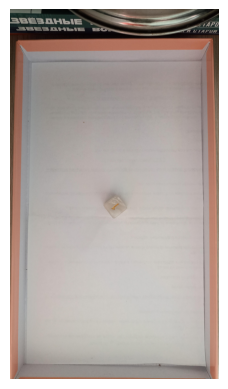

Labels: ['0 0.5043663594470046 0.5330255190311419 0.11041858678955443 0.06060121107266442']


In [ ]:
def load_image_and_label(image_folder, label_folder, filename):
    # Load image
    image_path = os.path.join(image_folder, filename)
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None, None

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None, None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with matplotlib

    # Construct the corresponding label file path
    label_filename = filename.replace('.jpg', '.txt')  # or adjust if your images are in another format
    label_path = os.path.join(label_folder, label_filename)

    # Check if the label file exists
    if not os.path.exists(label_path):
        print(f"Label file not found: {label_path}")
        return image, None

    # Load label
    with open(label_path, 'r') as f:
        labels = f.readlines()  # Read all label lines

    return image, labels

# Example of loading a single image and its label
filename = 'IMG_20230905_175525_jpg.rf.dfcdb35fa595310bc4d9c2d0201339bf.jpg'  # Ensure this matches an actual filename
image, labels = load_image_and_label(train_images_path, train_labels_path, filename)

if image is not None:
    # Display the image if loaded successfully
    plt.imshow(image)
    plt.axis('off')
    plt.show()

if labels is not None:
    print("Labels:", labels)


# Step 1: Resize and Normalize Images

In [ ]:
import cv2
import os

def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocesses an image for model training.

    Args:
        image_path (str): The path to the image file.
        target_size (tuple): The desired (width, height) for resizing the image.

    Returns:
        numpy.ndarray: The preprocessed image, resized and normalized.
    """

    # Load the image from the specified path
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    # Resize the image to the target dimensions specified (default is 224x224)
    image = cv2.resize(image, target_size)

    # Normalize the pixel values to the range [0, 1] by dividing by 255.0
    # This helps the model train more effectively by standardizing the input
    image = image / 255.0

    # Return the preprocessed image
    return image


# Step 2: Parse Label Files

In [ ]:
import cv2
import os

def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocesses an image for model training.

    Args:
        image_path (str): The path to the image file.
        target_size (tuple): The desired (width, height) for resizing the image.

    Returns:
        numpy.ndarray: The preprocessed image, resized and normalized.
    """

    # Load the image from the specified path
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    # Resize the image to the target dimensions specified (default is 224x224)
    image = cv2.resize(image, target_size)

    # Normalize the pixel values to the range [0, 1] by dividing by 255.0
    # This helps the model train more effectively by standardizing the input
    image = image / 255.0

    # Return the preprocessed image
    return image

In [ ]:
def preprocess_dataset(image_folder, label_folder, target_size=(224, 224)):
    images = []
    bboxes = []  # Bounding boxes and classes

    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg'):  # Adjust if your images have a different extension
            # Process image
            image_path = os.path.join(image_folder, filename)
            image = preprocess_image(image_path, target_size)
            if image is None:
                continue
            images.append(image)

            # Process labels
            label_path = os.path.join(label_folder, filename.replace('.jpg', '.txt'))
            if os.path.exists(label_path):
                labels = load_labels(label_path)
                bboxes.append(labels)
            else:
                print(f"Label file not found for {filename}, skipping labels.")
                bboxes.append([])  # No labels for this image

    return np.array(images), bboxes


# Step 3: Apply Preprocessing to the Entire Dataset

In [ ]:
train_images, train_bboxes = preprocess_dataset(train_images_path, train_labels_path)
valid_images, valid_bboxes = preprocess_dataset(valid_images_path, valid_labels_path)
test_images, test_bboxes = preprocess_dataset(test_images_path, test_labels_path)


#  YAML File for Train, Validation, and Test Sets

In [ ]:
# Write the YAML configuration file with train, val, and test sets
dataset_yaml = """
path: /content/drive/MyDrive/Midterm  # Replace with the actual path to your dataset folder
train: train/images
val: valid/images
test: test/images

names:
  0: "1"
  1: "2"
  2: "3"
  3: "4"
  4: "5"
  5: "6"
"""

# Save the YAML file
with open("dice.yaml", "w") as f:
    f.write(dataset_yaml)


# Train the YOLOv8 Model with Train and Validation Sets

In [ ]:
from ultralytics import YOLO

# Load a YOLOv8 model; 'yolov8n.pt' is the nano version, which is lightweight and faster to train
model = YOLO('yolov8n.pt')

# Train the model
results = model.train(data='dice.yaml', epochs=100, imgsz=416, batch=16, name='dice_detection')


100%|██████████| 6.25M/6.25M [00:00<00:00, 209MB/s]

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dice.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=dice_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 755k/755k [00:00<00:00, 78.4MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Midterm/train/labels... 211 images, 0 backgrounds, 0 corrupt: 100%|██████████| 211/211 [00:02<00:00, 76.16it/s]


train: New cache created: /content/drive/MyDrive/Midterm/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Midterm/valid/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 96.06it/s] 

val: New cache created: /content/drive/MyDrive/Midterm/valid/labels.cache


Plotting labels to runs/detect/dice_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/dice_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G       1.98      4.369      1.125         19        416: 100%|██████████| 14/14 [01:35<00:00,  6.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]

                   all         20         75    0.00081     0.0547     0.0103    0.00555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.665      2.987      0.953         13        416: 100%|██████████| 14/14 [01:23<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.06s/it]

                   all         20         75    0.00871      0.698     0.0956     0.0307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.511      2.461     0.9287         20        416: 100%|██████████| 14/14 [01:21<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]

                   all         20         75     0.0115      0.936      0.201      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.343      2.197     0.9061         26        416: 100%|██████████| 14/14 [01:24<00:00,  6.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]

                   all         20         75     0.0124          1      0.239       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.234       2.13     0.8929         22        416: 100%|██████████| 14/14 [01:22<00:00,  5.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]

                   all         20         75      0.148      0.852      0.215      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.264      2.063     0.8954         23        416: 100%|██████████| 14/14 [01:20<00:00,  5.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

                   all         20         75      0.171      0.417      0.225      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.236      2.058     0.8908          9        416: 100%|██████████| 14/14 [01:25<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]

                   all         20         75      0.167      0.524       0.22      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.242      2.073     0.8846         11        416: 100%|██████████| 14/14 [01:21<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]

                   all         20         75      0.167      0.956      0.223      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.158      1.958     0.8836         19        416: 100%|██████████| 14/14 [01:22<00:00,  5.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]

                   all         20         75      0.167      0.928      0.222      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.131      1.938     0.8729          6        416: 100%|██████████| 14/14 [01:24<00:00,  6.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

                   all         20         75      0.164      0.989      0.209      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.101      1.931     0.8612         10        416: 100%|██████████| 14/14 [01:23<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]

                   all         20         75      0.168      0.959      0.229      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.104      1.901     0.8587         25        416: 100%|██████████| 14/14 [01:22<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]

                   all         20         75      0.163      0.987      0.267      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.048      1.848     0.8623          8        416: 100%|██████████| 14/14 [01:20<00:00,  5.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

                   all         20         75      0.163      0.989      0.251      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.079      1.851     0.8553          9        416: 100%|██████████| 14/14 [01:24<00:00,  6.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

                   all         20         75      0.169      0.905      0.278      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.053      1.815     0.8632         16        416: 100%|██████████| 14/14 [01:19<00:00,  5.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]

                   all         20         75      0.169      0.972      0.301      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.028      1.818     0.8505         12        416: 100%|██████████| 14/14 [01:21<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]

                   all         20         75      0.164      0.815       0.27      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G     0.9951      1.796     0.8508         13        416: 100%|██████████| 14/14 [01:24<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

                   all         20         75      0.171      0.905      0.269      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.9814      1.762     0.8506         27        416: 100%|██████████| 14/14 [01:21<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

                   all         20         75      0.221      0.638      0.342      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.9727      1.729     0.8488         11        416: 100%|██████████| 14/14 [01:21<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]

                   all         20         75       0.23      0.896      0.364      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.9741      1.683     0.8412         22        416: 100%|██████████| 14/14 [01:22<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

                   all         20         75       0.23      0.645       0.37      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G     0.9669      1.683     0.8527         15        416: 100%|██████████| 14/14 [01:26<00:00,  6.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]

                   all         20         75      0.265      0.638      0.389      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      0.945      1.634     0.8447         14        416: 100%|██████████| 14/14 [01:24<00:00,  6.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]

                   all         20         75      0.275      0.733      0.396      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G     0.9332      1.656     0.8411          6        416: 100%|██████████| 14/14 [01:22<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

                   all         20         75      0.294       0.86      0.431      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      0.983      1.596     0.8415         18        416: 100%|██████████| 14/14 [01:23<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

                   all         20         75      0.287      0.905      0.397      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G     0.9753      1.596     0.8449         10        416: 100%|██████████| 14/14 [01:22<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

                   all         20         75       0.28      0.915      0.402      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G     0.9357      1.577      0.841         22        416: 100%|██████████| 14/14 [01:24<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.81s/it]

                   all         20         75      0.283      0.829      0.366      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      0.939      1.534     0.8366         19        416: 100%|██████████| 14/14 [01:23<00:00,  5.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]

                   all         20         75      0.265      0.805      0.397       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.9662      1.557     0.8481         22        416: 100%|██████████| 14/14 [01:23<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]

                   all         20         75      0.288      0.872      0.408      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.9166      1.511     0.8505         12        416: 100%|██████████| 14/14 [01:25<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

                   all         20         75      0.292      0.825      0.425      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G     0.9342      1.557     0.8386         19        416: 100%|██████████| 14/14 [01:24<00:00,  6.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]

                   all         20         75      0.277      0.854      0.409      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G     0.8958      1.516     0.8363         22        416: 100%|██████████| 14/14 [01:24<00:00,  6.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]

                   all         20         75      0.318      0.891      0.433       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.9507      1.485     0.8486         22        416: 100%|██████████| 14/14 [01:24<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

                   all         20         75      0.318       0.82      0.457      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G     0.9235      1.459     0.8358         10        416: 100%|██████████| 14/14 [01:24<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]

                   all         20         75      0.323      0.798      0.457      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G     0.8852      1.443     0.8374          9        416: 100%|██████████| 14/14 [01:26<00:00,  6.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

                   all         20         75       0.32      0.813      0.445       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.8992      1.441     0.8263         32        416: 100%|██████████| 14/14 [01:22<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.00s/it]

                   all         20         75       0.29       0.67      0.404      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.8942      1.485     0.8375         16        416: 100%|██████████| 14/14 [01:23<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]

                   all         20         75      0.278      0.733      0.387      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.9226      1.425     0.8441         16        416: 100%|██████████| 14/14 [01:24<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

                   all         20         75      0.341      0.771      0.426      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.9231      1.395     0.8435         17        416: 100%|██████████| 14/14 [01:25<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

                   all         20         75      0.324      0.849      0.441       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.9246      1.375     0.8352         16        416: 100%|██████████| 14/14 [01:24<00:00,  6.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]

                   all         20         75      0.359      0.799      0.448      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.8961      1.358     0.8311         25        416: 100%|██████████| 14/14 [01:24<00:00,  6.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

                   all         20         75       0.34      0.776      0.448      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.8921      1.386     0.8427         14        416: 100%|██████████| 14/14 [01:23<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]

                   all         20         75      0.302      0.813      0.444      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.8888      1.328     0.8291         11        416: 100%|██████████| 14/14 [01:20<00:00,  5.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.52s/it]

                   all         20         75      0.329      0.771      0.448      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.9056      1.359     0.8238          9        416: 100%|██████████| 14/14 [01:22<00:00,  5.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]

                   all         20         75      0.335      0.725      0.457      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.8843      1.322     0.8418          9        416: 100%|██████████| 14/14 [01:23<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

                   all         20         75      0.367      0.876      0.479      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.9013      1.311     0.8288         24        416: 100%|██████████| 14/14 [01:19<00:00,  5.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]

                   all         20         75      0.333      0.868      0.466      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      0.875      1.281     0.8338         10        416: 100%|██████████| 14/14 [01:21<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]

                   all         20         75      0.307      0.711       0.48      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.8857      1.286     0.8362         31        416: 100%|██████████| 14/14 [01:22<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

                   all         20         75      0.324      0.786      0.472      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.8168      1.273     0.8284          5        416: 100%|██████████| 14/14 [01:23<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

                   all         20         75      0.298      0.714      0.447      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.8538      1.281     0.8238         23        416: 100%|██████████| 14/14 [01:21<00:00,  5.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]

                   all         20         75      0.303       0.87      0.467      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.8608      1.296     0.8333         14        416: 100%|██████████| 14/14 [01:21<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

                   all         20         75      0.346      0.831       0.47      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.8623       1.27     0.8291          8        416: 100%|██████████| 14/14 [01:21<00:00,  5.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

                   all         20         75      0.311      0.721      0.469      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.8619      1.267     0.8319         15        416: 100%|██████████| 14/14 [01:23<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]

                   all         20         75      0.329      0.751      0.448       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.8246      1.217     0.8142         23        416: 100%|██████████| 14/14 [01:22<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]

                   all         20         75      0.368      0.852      0.472      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.8653      1.216     0.8451         17        416: 100%|██████████| 14/14 [01:20<00:00,  5.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

                   all         20         75       0.36      0.829      0.491      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.8472      1.239     0.8354         22        416: 100%|██████████| 14/14 [01:23<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

                   all         20         75      0.368      0.802      0.486      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.8101      1.197      0.819         12        416: 100%|██████████| 14/14 [01:22<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]

                   all         20         75       0.37      0.883      0.497      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.8734      1.179     0.8388         24        416: 100%|██████████| 14/14 [01:21<00:00,  5.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]

                   all         20         75      0.384      0.828      0.526      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      0.845      1.212     0.8314         15        416: 100%|██████████| 14/14 [01:21<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]

                   all         20         75      0.425      0.691      0.527      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.8392      1.196     0.8185         13        416: 100%|██████████| 14/14 [01:22<00:00,  5.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]

                   all         20         75      0.353      0.793      0.489      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.8318      1.123     0.8347         18        416: 100%|██████████| 14/14 [01:21<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]

                   all         20         75      0.351      0.844      0.482      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.8321      1.087     0.8296         17        416: 100%|██████████| 14/14 [01:22<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]

                   all         20         75      0.383      0.733      0.511        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      0.831      1.139     0.8296         17        416: 100%|██████████| 14/14 [01:22<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

                   all         20         75      0.359      0.745      0.493      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.7906      1.083     0.8273         19        416: 100%|██████████| 14/14 [01:24<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

                   all         20         75      0.403      0.675      0.487      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      0.829        1.1     0.8247         19        416: 100%|██████████| 14/14 [01:22<00:00,  5.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.22s/it]

                   all         20         75      0.363      0.623      0.481      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      0.835      1.134      0.822         15        416: 100%|██████████| 14/14 [01:20<00:00,  5.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]

                   all         20         75      0.378      0.736      0.534      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.8079      1.055     0.8256         12        416: 100%|██████████| 14/14 [01:23<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

                   all         20         75      0.367       0.74      0.467      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.7795      1.071     0.8164         18        416: 100%|██████████| 14/14 [01:22<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

                   all         20         75      0.402      0.826      0.505      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.8002      1.034     0.8183         11        416: 100%|██████████| 14/14 [01:24<00:00,  6.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

                   all         20         75      0.408      0.781      0.513      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.7846      1.078     0.8292         19        416: 100%|██████████| 14/14 [01:23<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]

                   all         20         75      0.395      0.784      0.524      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.8007      1.017     0.8309         15        416: 100%|██████████| 14/14 [01:22<00:00,  5.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]

                   all         20         75      0.453      0.629      0.531      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.8099      1.042     0.8306         11        416: 100%|██████████| 14/14 [01:21<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

                   all         20         75      0.392      0.789      0.515      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.7954     0.9911     0.8173         11        416: 100%|██████████| 14/14 [01:26<00:00,  6.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]

                   all         20         75      0.467      0.671      0.552      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.7533      1.037     0.8127         18        416: 100%|██████████| 14/14 [01:23<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]

                   all         20         75      0.414      0.728      0.507      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.7949      1.004     0.8247         23        416: 100%|██████████| 14/14 [01:25<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

                   all         20         75      0.371      0.738      0.495      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.8106     0.9825     0.8273         13        416: 100%|██████████| 14/14 [01:22<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]

                   all         20         75      0.384      0.725      0.494      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.8104     0.9877     0.8249         13        416: 100%|██████████| 14/14 [01:21<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]

                   all         20         75      0.376      0.786      0.478      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.8069     0.9828      0.827         31        416: 100%|██████████| 14/14 [01:22<00:00,  5.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

                   all         20         75       0.39        0.7      0.483      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.7758     0.9471     0.8144         25        416: 100%|██████████| 14/14 [01:21<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

                   all         20         75      0.397      0.743      0.489      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.7661     0.9507     0.8157         15        416: 100%|██████████| 14/14 [01:23<00:00,  5.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]

                   all         20         75      0.398      0.793      0.524      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.7471     0.9607     0.8138         10        416: 100%|██████████| 14/14 [01:22<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]

                   all         20         75      0.436      0.674      0.513      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      0.767     0.9669     0.8254         19        416: 100%|██████████| 14/14 [01:21<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.30s/it]

                   all         20         75      0.426      0.763      0.511      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.7689     0.9732       0.82         24        416: 100%|██████████| 14/14 [01:22<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]

                   all         20         75      0.448      0.697      0.532      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.7466     0.8877     0.8246         14        416: 100%|██████████| 14/14 [01:22<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]

                   all         20         75      0.411      0.721      0.536      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      0.763     0.9411     0.8168         32        416: 100%|██████████| 14/14 [01:24<00:00,  6.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]

                   all         20         75      0.395       0.75      0.499      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.7595     0.9266      0.818         14        416: 100%|██████████| 14/14 [01:23<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]

                   all         20         75      0.384      0.737      0.497      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.7292      0.882     0.8119         12        416: 100%|██████████| 14/14 [01:20<00:00,  5.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]

                   all         20         75      0.387      0.801      0.547      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.7236     0.8716     0.8073         13        416: 100%|██████████| 14/14 [01:24<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]

                   all         20         75      0.385       0.76      0.531      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.7477     0.9015     0.8188          7        416: 100%|██████████| 14/14 [01:24<00:00,  6.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]

                   all         20         75      0.368      0.714      0.519      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.7243     0.8563     0.8179         16        416: 100%|██████████| 14/14 [01:23<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

                   all         20         75      0.378       0.72      0.516      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.7489     0.8868     0.8168         24        416: 100%|██████████| 14/14 [01:25<00:00,  6.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]

                   all         20         75      0.374      0.725        0.5      0.398


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.8154     0.9014     0.8272         15        416: 100%|██████████| 14/14 [01:24<00:00,  6.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

                   all         20         75      0.408      0.735      0.492      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.7914      0.879     0.8236          5        416: 100%|██████████| 14/14 [01:21<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]

                   all         20         75      0.433      0.714      0.498      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.8024     0.9131     0.8139          6        416: 100%|██████████| 14/14 [01:21<00:00,  5.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

                   all         20         75      0.402      0.778      0.495      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.7981     0.8572     0.8253         14        416: 100%|██████████| 14/14 [01:23<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]

                   all         20         75      0.359      0.731      0.463      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.7739     0.7872     0.8268         11        416: 100%|██████████| 14/14 [01:22<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]

                   all         20         75      0.365      0.707      0.476      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.7837      0.816     0.8216          9        416: 100%|██████████| 14/14 [01:21<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]

                   all         20         75      0.375       0.72      0.474      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.7504     0.7676     0.8223         14        416: 100%|██████████| 14/14 [01:21<00:00,  5.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]

                   all         20         75      0.405      0.738      0.481      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.7536      0.792     0.8207         10        416: 100%|██████████| 14/14 [01:23<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

                   all         20         75      0.426      0.711      0.488      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.7648     0.7532     0.8218         20        416: 100%|██████████| 14/14 [01:21<00:00,  5.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

                   all         20         75      0.412      0.719      0.482      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G      0.756      0.763     0.8258         13        416: 100%|██████████| 14/14 [01:24<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]

                   all         20         75      0.406      0.732      0.484      0.388



100 epochs completed in 2.428 hours.
Optimizer stripped from runs/detect/dice_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/dice_detection/weights/best.pt, 6.2MB

Validating runs/detect/dice_detection/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


                   all         20         75      0.472      0.663      0.552      0.438
                     1         13         17      0.914          1      0.989      0.771
                     2         12         15      0.433      0.408      0.467      0.359
                     3          8         13      0.497      0.456      0.514      0.442
                     4          4          5      0.139        0.6       0.18       0.15
                     5         10         12      0.447      0.667      0.534      0.429
                     6          9         13      0.404      0.846       0.63       0.48
Speed: 0.8ms preprocess, 76.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/dice_detection


# Evaluate the Model on the Test Set

In [ ]:
# Load the trained model
from ultralytics import YOLO
model = YOLO('/content/best.pt')  # Path to your best weights file

# Run validation to get metrics
metrics = model.val(data='dice.yaml')

import numpy as np

# Display the general metrics for all classes
print("Model Evaluation Metrics:")
print(f"Precision: {np.mean(metrics.box.p):.4f}")
print(f"Recall: {np.mean(metrics.box.r):.4f}")
print(f"mAP@0.5: {np.mean(metrics.box.map50):.4f}")
print(f"mAP@0.5:0.95: {np.mean(metrics.box.map):.4f}")
print(f"Speed: {metrics.speed} ms per image")




print(dir(metrics))


Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 12.0MB/s]
val: Scanning /content/drive/MyDrive/Midterm/valid/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.98s/it]


                   all         20         75      0.459      0.708      0.547      0.435
                     1         13         17       0.91          1      0.989      0.772
                     2         12         15      0.442      0.475       0.45      0.344
                     3          8         13      0.467      0.462      0.509      0.437
                     4          4          5      0.159        0.8      0.165      0.136
                     5         10         12      0.393      0.667      0.534      0.429
                     6          9         13      0.383      0.846      0.635      0.492
Speed: 2.0ms preprocess, 97.8ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val2
Model Evaluation Metrics:
Precision: 0.4590
Recall: 0.7082
mAP@0.5: 0.5470
mAP@0.5:0.95: 0.4348
Speed: {'preprocess': 1.9582152366638184, 'inference': 97.79026508331299, 'loss': 0.00026226043701171875, 'postprocess': 1.7228960990905762} ms per image
['__class_

In [ ]:
# Run inference on test images
results = model.predict(source='/content/drive/MyDrive/Midterm/test/images', save=True, conf=0.5)



image 1/20 /content/drive/MyDrive/Midterm/test/images/IMG_20230905_180744_jpg.rf.4f0b9f6ab56efc97d749053a7c1c515b.jpg: 416x256 1 3, 2 5s, 1 6, 57.5ms
image 2/20 /content/drive/MyDrive/Midterm/test/images/IMG_20230905_180814_jpg.rf.6a3375960392b21af61496b56c41684e.jpg: 416x256 1 1, 1 4, 2 6s, 56.6ms
image 3/20 /content/drive/MyDrive/Midterm/test/images/IMG_20230905_180848_jpg.rf.3c84e6b6a56f9c8e16345911c867062c.jpg: 416x256 1 4, 1 5, 2 6s, 60.1ms
image 4/20 /content/drive/MyDrive/Midterm/test/images/IMG_20230905_180927_jpg.rf.9c7f56fb92ebc72ec5903b0f42cd6ebf.jpg: 416x256 1 1, 1 4, 1 5, 2 6s, 56.3ms
image 5/20 /content/drive/MyDrive/Midterm/test/images/IMG_20230905_180932_jpg.rf.6c85f85d2208ab65090806a84913bdde.jpg: 416x256 2 1s, 1 3, 1 5, 2 6s, 58.3ms
image 6/20 /content/drive/MyDrive/Midterm/test/images/IMG_20230905_180944_jpg.rf.d23b2ca19fd3eda60b05b0e66ed13c9c.jpg: 416x256 2 4s, 2 5s, 1 6, 66.3ms
image 7/20 /content/drive/MyDrive/Midterm/test/images/IMG_20230905_181053_jpg.rf.8a75d8

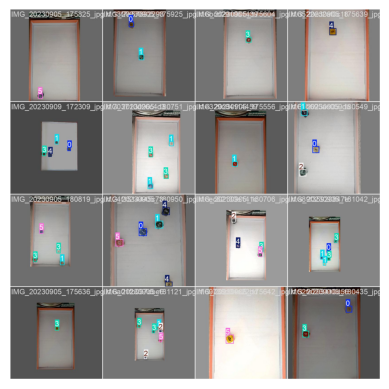

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Display a sample prediction
image_path = '/content/runs/detect/dice_detection/train_batch1260.jpg'  # Replace with the path to a sample predicted image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()


# Load the Trained Model

In [ ]:
from ultralytics import YOLO

# Load the model with the trained weights
model = YOLO('/content/best.pt')


# Testing the model

In [ ]:
# Path to the image you want to test
image_path = 'test-pic.jpg'  # Replace with the actual image path

# Run inference
results = model.predict(source=image_path, save=True, conf=0.25)



image 1/1 /content/test-pic.jpg: 416x256 1 1, 1 4, 2 6s, 72.8ms
Speed: 3.7ms preprocess, 72.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 256)
Results saved to runs/detect/predict7


# Display result

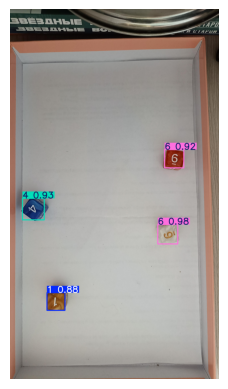

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to the predicted image (the output will be in runs/predict/)
output_image_path = '/content/runs/detect/predict7/test-pic.jpg'
image = Image.open(output_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()


# Re-train model

In [ ]:
from ultralytics import YOLO

# Load your trained model
model = YOLO('/content/runs/detect/dice_detection/weights/best.pt')  # Path to your best weights

# Retrain with data augmentation enabled
results = model.train(data='dice.yaml', epochs=50, imgsz=416, batch=16, name='dice_detection_augmented', augment=True)


Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/dice_detection/weights/best.pt, data=dice.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=dice_detection_augmented2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

train: Scanning /content/drive/MyDrive/Midterm/train/labels.cache... 211 images, 0 backgrounds, 0 corrupt: 100%|██████████| 211/211 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Midterm/valid/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]

Plotting labels to runs/detect/dice_detection_augmented2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/dice_detection_augmented2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G     0.7925      1.037     0.8217         19        416: 100%|██████████| 14/14 [01:30<00:00,  6.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

                   all         20         75      0.372      0.711       0.49      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.7551     0.9722      0.809         13        416: 100%|██████████| 14/14 [01:22<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

                   all         20         75      0.399      0.784      0.516      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.8134      1.024     0.8291         20        416: 100%|██████████| 14/14 [01:20<00:00,  5.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]

                   all         20         75      0.369      0.685       0.53      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.8395      1.059     0.8256         26        416: 100%|██████████| 14/14 [01:21<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]

                   all         20         75      0.471      0.564      0.555      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.8346      1.101     0.8284         22        416: 100%|██████████| 14/14 [01:23<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

                   all         20         75      0.376      0.774      0.503      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.8136      1.048      0.825         23        416: 100%|██████████| 14/14 [01:20<00:00,  5.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]

                   all         20         75       0.39       0.75      0.488      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      0.842      1.002     0.8285          9        416: 100%|██████████| 14/14 [01:20<00:00,  5.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]

                   all         20         75      0.431      0.638      0.505      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.8538      1.039     0.8256         11        416: 100%|██████████| 14/14 [01:19<00:00,  5.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

                   all         20         75      0.395       0.87      0.539      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.8458      1.005     0.8364         19        416: 100%|██████████| 14/14 [01:22<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

                   all         20         75      0.399      0.699      0.516      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.8213       1.01     0.8279          6        416: 100%|██████████| 14/14 [01:20<00:00,  5.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]

                   all         20         75      0.486      0.575      0.502      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.8532      1.066      0.824         10        416: 100%|██████████| 14/14 [01:22<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]

                   all         20         75      0.412      0.748      0.557      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.8495      1.003     0.8205         25        416: 100%|██████████| 14/14 [01:21<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

                   all         20         75       0.37      0.623      0.472      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.8179      1.009      0.827          8        416: 100%|██████████| 14/14 [01:21<00:00,  5.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

                   all         20         75      0.393       0.76      0.447      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      0.817      1.109     0.8217          9        416: 100%|██████████| 14/14 [01:23<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

                   all         20         75      0.549      0.593      0.533      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      0.808     0.9464     0.8297         16        416: 100%|██████████| 14/14 [01:20<00:00,  5.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]

                   all         20         75      0.378      0.727      0.498      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.8042      1.018     0.8189         12        416: 100%|██████████| 14/14 [01:21<00:00,  5.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

                   all         20         75      0.432      0.575      0.483      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.8174     0.9702     0.8249         13        416: 100%|██████████| 14/14 [01:21<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]

                   all         20         75      0.346      0.729      0.461      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.8018     0.9907     0.8232         27        416: 100%|██████████| 14/14 [01:23<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

                   all         20         75      0.358      0.727       0.49      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      0.788     0.9419     0.8217         11        416: 100%|██████████| 14/14 [01:18<00:00,  5.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]

                   all         20         75       0.39      0.755      0.488      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.7986      0.924     0.8151         22        416: 100%|██████████| 14/14 [01:21<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]

                   all         20         75      0.454      0.709      0.515      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.7952     0.9492     0.8297         15        416: 100%|██████████| 14/14 [01:21<00:00,  5.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

                   all         20         75      0.454      0.703      0.547      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      0.792     0.9153     0.8235         14        416: 100%|██████████| 14/14 [01:22<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]

                   all         20         75      0.486      0.702      0.601      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.7836     0.9209     0.8205          6        416: 100%|██████████| 14/14 [01:21<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.59s/it]

                   all         20         75      0.529      0.655      0.596      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.8011     0.8968     0.8162         18        416: 100%|██████████| 14/14 [01:22<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.12s/it]

                   all         20         75      0.536      0.668      0.583      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.7628     0.8474     0.8191         10        416: 100%|██████████| 14/14 [01:20<00:00,  5.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]

                   all         20         75      0.498      0.727      0.598      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      0.778     0.8296      0.818         22        416: 100%|██████████| 14/14 [01:23<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

                   all         20         75       0.54      0.605      0.564      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.7821     0.8303     0.8156         19        416: 100%|██████████| 14/14 [01:21<00:00,  5.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]

                   all         20         75      0.546      0.562      0.564      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.7669     0.8545     0.8207         22        416: 100%|██████████| 14/14 [01:21<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]

                   all         20         75      0.461       0.65      0.539      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.7621     0.8387     0.8251         12        416: 100%|██████████| 14/14 [01:21<00:00,  5.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

                   all         20         75      0.442      0.609      0.492      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.7487     0.8214     0.8122         19        416: 100%|██████████| 14/14 [01:24<00:00,  6.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

                   all         20         75      0.509      0.687      0.594      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.7664     0.7997     0.8179         22        416: 100%|██████████| 14/14 [01:19<00:00,  5.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]

                   all         20         75      0.521      0.613      0.552       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.7889     0.8082     0.8242         22        416: 100%|██████████| 14/14 [01:23<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

                   all         20         75      0.571      0.655      0.552      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.7509     0.7735     0.8138         10        416: 100%|██████████| 14/14 [01:22<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]

                   all         20         75      0.553      0.607      0.584      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.7044     0.7499      0.811          9        416: 100%|██████████| 14/14 [01:24<00:00,  6.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

                   all         20         75       0.49      0.646      0.555       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.7275     0.7506      0.806         32        416: 100%|██████████| 14/14 [01:23<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]

                   all         20         75      0.436      0.704      0.545      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.7225     0.7392     0.8152         16        416: 100%|██████████| 14/14 [01:21<00:00,  5.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]

                   all         20         75      0.411      0.684       0.56      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.7137     0.7119     0.8161         16        416: 100%|██████████| 14/14 [01:23<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

                   all         20         75      0.553      0.599       0.57      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.7315     0.7227     0.8168         17        416: 100%|██████████| 14/14 [01:23<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

                   all         20         75      0.488      0.659      0.543       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.7087     0.6885     0.8065         16        416: 100%|██████████| 14/14 [01:23<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]

                   all         20         75      0.552      0.541      0.533      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.7084     0.7021     0.8061         25        416: 100%|██████████| 14/14 [01:20<00:00,  5.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

                   all         20         75      0.413      0.637      0.508      0.416


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.8038     0.7167     0.8297          8        416: 100%|██████████| 14/14 [01:22<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

                   all         20         75      0.484      0.613      0.527      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.7754     0.6819      0.822          9        416: 100%|██████████| 14/14 [01:20<00:00,  5.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]

                   all         20         75      0.532      0.625      0.527      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.7644     0.6382     0.8223          9        416: 100%|██████████| 14/14 [01:20<00:00,  5.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]

                   all         20         75      0.418       0.65      0.537      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.7954      0.647     0.8283          3        416: 100%|██████████| 14/14 [01:20<00:00,  5.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

                   all         20         75      0.508       0.51       0.58      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.7452     0.6098     0.8172         14        416: 100%|██████████| 14/14 [01:19<00:00,  5.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]

                   all         20         75       0.46      0.563      0.552      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.7586     0.6321     0.8224         16        416: 100%|██████████| 14/14 [01:19<00:00,  5.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

                   all         20         75      0.427      0.676      0.552      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.7302     0.5842     0.8304         11        416: 100%|██████████| 14/14 [01:19<00:00,  5.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]

                   all         20         75       0.44      0.675      0.547      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.7348     0.6882     0.8159          4        416: 100%|██████████| 14/14 [01:18<00:00,  5.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

                   all         20         75      0.445      0.713      0.554      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.7247     0.5921     0.8113          9        416: 100%|██████████| 14/14 [01:22<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]

                   all         20         75      0.432      0.729      0.565      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.7199     0.5493     0.8123          8        416: 100%|██████████| 14/14 [01:18<00:00,  5.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]

                   all         20         75      0.431      0.707      0.569      0.455



50 epochs completed in 1.196 hours.
Optimizer stripped from runs/detect/dice_detection_augmented2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/dice_detection_augmented2/weights/best.pt, 6.2MB

Validating runs/detect/dice_detection_augmented2/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.03s/it]


                   all         20         75      0.427      0.816       0.58      0.461
                     1         13         17      0.799          1      0.995      0.767
                     2         12         15       0.52      0.533       0.42      0.315
                     3          8         13      0.309      0.923      0.518      0.436
                     4          4          5     0.0872        0.6      0.227        0.2
                     5         10         12       0.37      0.917      0.586      0.461
                     6          9         13      0.477      0.923      0.733      0.586
Speed: 0.8ms preprocess, 204.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/dice_detection_augmented2


# Hog + SVM

## # Install necessary libraries

In [ ]:
!pip install opencv-python-headless scikit-learn

# Libraries

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Initialize Directories

In [ ]:
# Directories for your dataset
train_image_dir = '/content/drive/MyDrive/Midterm/train/images'
train_annotation_dir = '/content/drive/MyDrive/Midterm/train/labels'
test_image_dir = '/content/drive/MyDrive/Midterm/test/images'
test_annotation_dir = '/content/drive/MyDrive/Midterm/test/labels'
valid_image_dir = '/content/drive/MyDrive/Midterm/valid/images'
valid_annotation_dir = '/content/drive/MyDrive/Midterm/valid/labels'


#  Parse YOLO Annotations for Bounding Boxes

In [ ]:
def parse_yolo_annotation(annotation_path, img_width, img_height):
    bboxes = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])  # Adjust based on your class needs
            x_center, y_center, width, height = map(float, parts[1:])
            # Convert normalized coordinates to pixel values
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_height)
            bboxes.append((x_min, y_min, x_max, y_max))
    return bboxes


#  Prepare Dataset with Positive and Negative Samples

In [ ]:
import cv2
import os
import numpy as np
import glob

def prepare_dataset(image_dir, annotation_dir, crop_size=(64, 128), limit=None):
    images = []
    labels = []
    count = 0

    for annotation_path in glob.glob(os.path.join(annotation_dir, "*.txt")):
        if limit is not None and count >= limit:
            break

        image_path = os.path.join(image_dir, os.path.basename(annotation_path).replace('.txt', '.jpg'))
        image = cv2.imread(image_path)
        if image is None:
            continue

        img_height, img_width = image.shape[:2]
        bboxes = parse_yolo_annotation(annotation_path, img_width, img_height)

        # Process positive samples
        for (x_min, y_min, x_max, y_max) in bboxes:
            cropped_img = image[y_min:y_max, x_min:x_max]
            resized_img = cv2.resize(cropped_img, crop_size)
            normalized_img = resized_img.astype(np.float32) / 255.0  # Normalize pixel values
            images.append(normalized_img)
            labels.append(1)  # Label for the positive class

        # Add a negative sample (crop a region without any object)
        neg_sample = cv2.resize(image[0:128, 0:64], crop_size)
        normalized_neg_sample = neg_sample.astype(np.float32) / 255.0  # Normalize pixel values
        images.append(normalized_neg_sample)
        labels.append(0)  # Label for the negative class (no object)

        count += 1

    return images, labels

# Load training, validation, and testing datasets
train_images, train_labels = prepare_dataset(train_image_dir, train_annotation_dir)
val_images, val_labels = prepare_dataset(valid_image_dir, valid_annotation_dir)
test_images, test_labels = prepare_dataset(test_image_dir, test_annotation_dir, limit=5)


# Extract HOG Features

In [ ]:
hog = cv2.HOGDescriptor()

def extract_hog_features(images):
    images_uint8 = [(image * 255).astype(np.uint8) for image in images]
    return [hog.compute(image).flatten() for image in images_uint8]

train_features = extract_hog_features(train_images)
val_features = extract_hog_features(val_images)
test_features = extract_hog_features(test_images)


#  Train SVM Model Using HOG Features

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import time

param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [1000, 2000, 3000]
}

grid = GridSearchCV(LinearSVC(), param_grid, cv=5)
start_time = time.time()
grid.fit(train_features, train_labels)
training_time = time.time() - start_time

print("Best parameters found: ", grid.best_params_)
print("HOG-SVM model trained successfully in {:.2f} seconds.".format(training_time))


Best parameters found:  {'C': 0.1, 'max_iter': 1000}
HOG-SVM model trained successfully in 10.21 seconds.


# Evaluate Model on Validation and Test Sets

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Validation set evaluation
val_preds = grid.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
recall = recall_score(val_labels, val_preds)

print("Validation Accuracy:", val_accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Test set evaluation
test_preds = grid.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)

print("Testing Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


Validation Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Testing Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0


In [ ]:
print(f"Number of validation features: {len(val_features)}")
if len(val_features) > 0:
    print(f"Example validation feature vector (first): {val_features[0]}")
else:
    print("No validation features extracted. Check the image processing and feature extraction steps.")


Number of validation features: 95
Example validation feature vector (first): [0.01237085 0.05810046 0.23135251 ... 0.01927439 0.06499206 0.04249948]


In [ ]:
print(f"Number of validation images: {len(val_images)}")


Number of validation images: 95


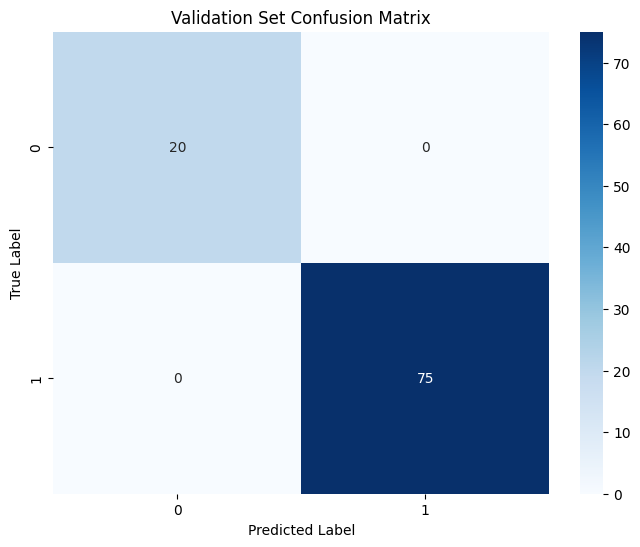

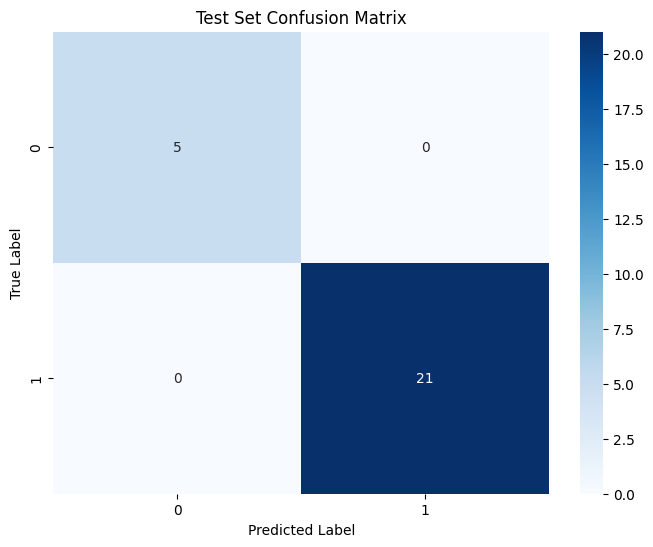

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for validation set
val_conf_matrix = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Confusion matrix for test set
test_conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Testing

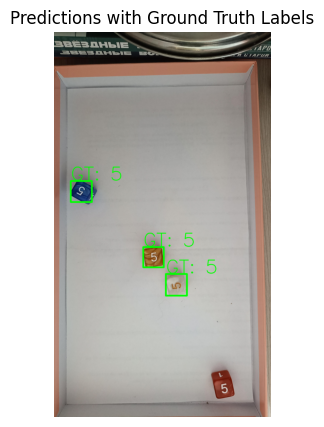

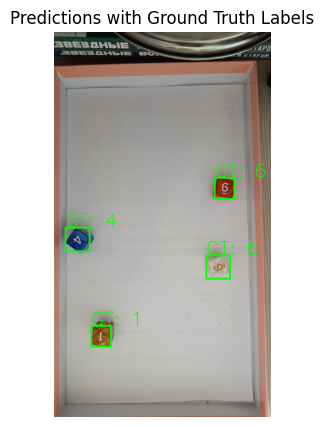

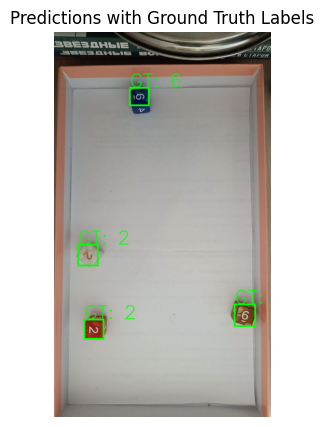

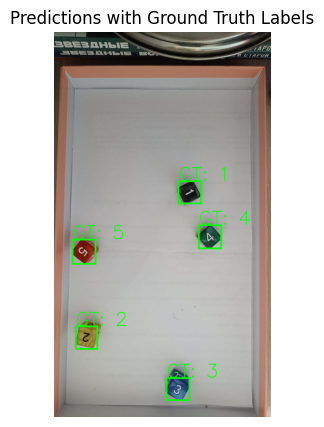

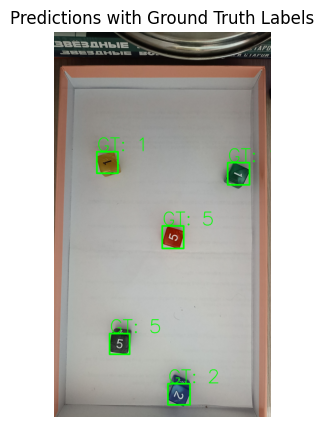

In [ ]:
import os
import cv2
import glob
import matplotlib.pyplot as plt

# Function to parse YOLO annotations and return bounding boxes with class IDs
def parse_yolo_annotation(annotation_path, img_width, img_height):
    bboxes = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 5:  # Ensure there are enough parts
                class_id, x_center, y_center, width, height = map(float, parts)
                x_center, y_center, width, height = (
                    x_center * img_width,
                    y_center * img_height,
                    width * img_width,
                    height * img_height
                )
                x_min = int(x_center - width / 2)
                y_min = int(y_center - height / 2)
                x_max = int(x_center + width / 2)
                y_max = int(y_center + height / 2)
                bboxes.append((x_min, y_min, x_max, y_max, int(class_id)))  # Include class_id
    return bboxes

# Function to visualize predictions with labels
def visualize_predictions(image_dir, annotations_dir, predictions, limit=5):
    count = 0
    class_names = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5", 5: "6"}  # Example class names, adjust based on your dataset

    for annotation_path in glob.glob(os.path.join(annotations_dir, "*.txt")):
        image_path = os.path.join(image_dir, os.path.basename(annotation_path).replace('.txt', '.jpg'))
        image = cv2.imread(image_path)

        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        img_height, img_width = image.shape[:2]
        bboxes = parse_yolo_annotation(annotation_path, img_width, img_height)

        # Draw the actual bounding boxes with class labels on the original image
        for bbox in bboxes:
            x_min, y_min, x_max, y_max, class_id = bbox
            label = class_names.get(class_id, "Unknown")  # Get class name from class ID
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 20)
            # Adjusted the position of the label text to ensure visibility
            cv2.putText(image, f'GT: {label}', (x_min, max(y_min - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 7.5, (0, 255, 0), 10)

        # Display the image with the ground truth annotations
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Predictions with Ground Truth Labels')
        plt.show()

        count += 1
        if count >= limit:
            break

# Example usage
# Replace with your actual test directories and predictions
hog_SVM_output = visualize_predictions(test_image_dir, test_annotation_dir, test_preds, limit=5)
